In [37]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12),
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [38]:
import pandas as pd
import os

def load_police_data():
    csv_path = os.path.join(os.path.join("police_data"), "crimes_2012_to_2017.csv")
    return pd.read_csv(csv_path, index_col=0)

## Load Data and get basic info about shape and values

In [39]:
police_data = load_police_data()
print(f'Shape of table: {police_data.shape}')
# Show Unique value count for each column
print(f'Unique values per column: \n{police_data.nunique()}')
police_data.tail(2)

Shape of table: (1456714, 22)
Unique values per column: 
ID                      1456714
Case Number             1456598
Date                     582146
Block                     32774
IUCR                        365
Primary Type                 33
Description                 342
Location Description        142
Arrest                        2
Domestic                      2
Beat                        302
District                     24
Ward                         50
Community Area               78
FBI Code                     26
X Coordinate              67714
Y Coordinate             111555
Year                          6
Updated On                  959
Latitude                 368076
Longitude                367942
Location                 368286
dtype: int64


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
6253257,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"
6253474,10508692,HZ250517,05/03/2016 11:38:00 PM,001XX E 75TH ST,5007,OTHER OFFENSE,OTHER WEAPONS VIOLATION,PARKING LOT/GARAGE(NON.RESID.),True,False,...,6.0,69.0,26,1178696.0,1855324.0,2016,05/10/2016 03:56:50 PM,41.758309,-87.620658,"(41.75830866, -87.620658418)"


## Format Data, drop/rename/add columns, convert to timeseries etc

In [40]:
drop_attributes = ['Location',
                   'ID',
                   'Case Number',
                   'IUCR',
                   'Block',
                   'Ward',
                   'Primary Type',
                   'Beat',
                   'X Coordinate',
                   'Community Area',
                   'Year',
                   'Latitude',
                   'Longitude',
                   'Y Coordinate',
                   'Updated On',
                   'Description',
                   'Location Description']

police_data = police_data.drop(columns=drop_attributes)

# Rename columns
police_data.rename(columns={
    'Arrest': 'Arrest Status',
    'Domestic': 'Domestic Status'
}, inplace=True)

# Convert to timeseries
# A lot (X50) faster when we provide the format
police_data['Date'] = pd.to_datetime(
    police_data['Date'], format='%m/%d/%Y %I:%M:%S %p')

# Set datetime as index, will not remove duplicates (verify_integrity=True would remove duplicates)
police_data = police_data.set_index('Date')

# Generate temp columns for plotting distributions
police_data['Year'] = police_data.index.year
police_data['Month'] = police_data.index.month
police_data['Day of the Year'] = police_data.index.day_of_year

# Drop rows with null values
police_data= police_data.dropna()
print(f'Shape of table: {police_data.shape}')

# Show Unique value count for each column
print(f'Unique values per column: \n{police_data.nunique()}')


Shape of table: (1456713, 7)
Unique values per column: 
Arrest Status        2
Domestic Status      2
District            24
FBI Code            26
Year                 6
Month               12
Day of the Year    366
dtype: int64


## Visualize Categorical Values

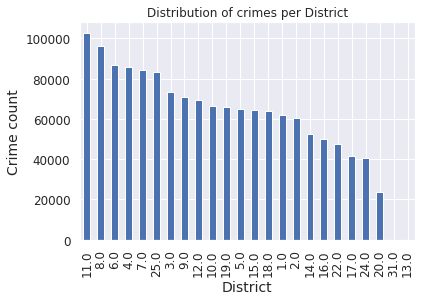

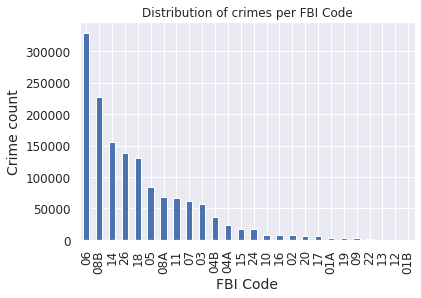

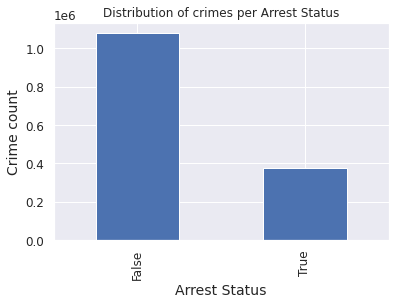

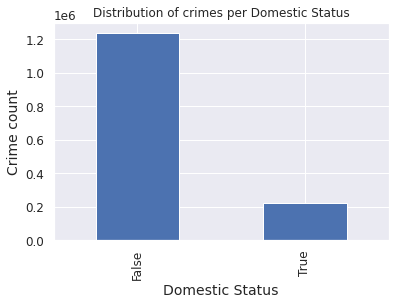

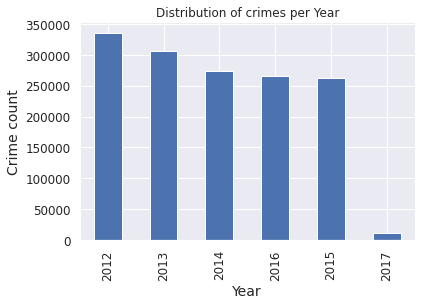

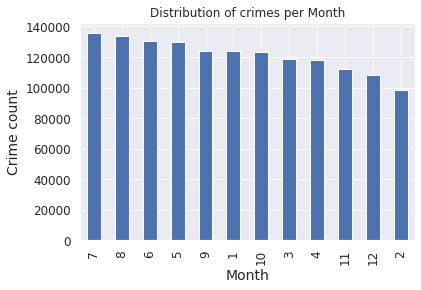

In [41]:
# Print bar diagrams for important columns
columns_hist = [
    'District',
    'FBI Code',
    'Arrest Status',
    'Domestic Status',
    'Year',
    'Month',
]

for column in columns_hist:
    police_data[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of crimes per {column}')
    plt.xlabel(column)
    plt.ylabel('Crime count')
    plt.show()

drop_attributes = [
    'Year',
    'Month',
    'Day of the Year'
]

police_data = police_data.drop(columns=drop_attributes)


## Timeseries Visualisation

In [42]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10), 'lines.marker':'o', 'lines.linewidth': 0.5})
# comment out to see all possible keys
# mpl.rcParams.keys()

# this helps with adding plot ticks on certain weekdays etc
import matplotlib.dates as mdates

Text(0.5, 1.0, 'Weekly crime count across 5 years')

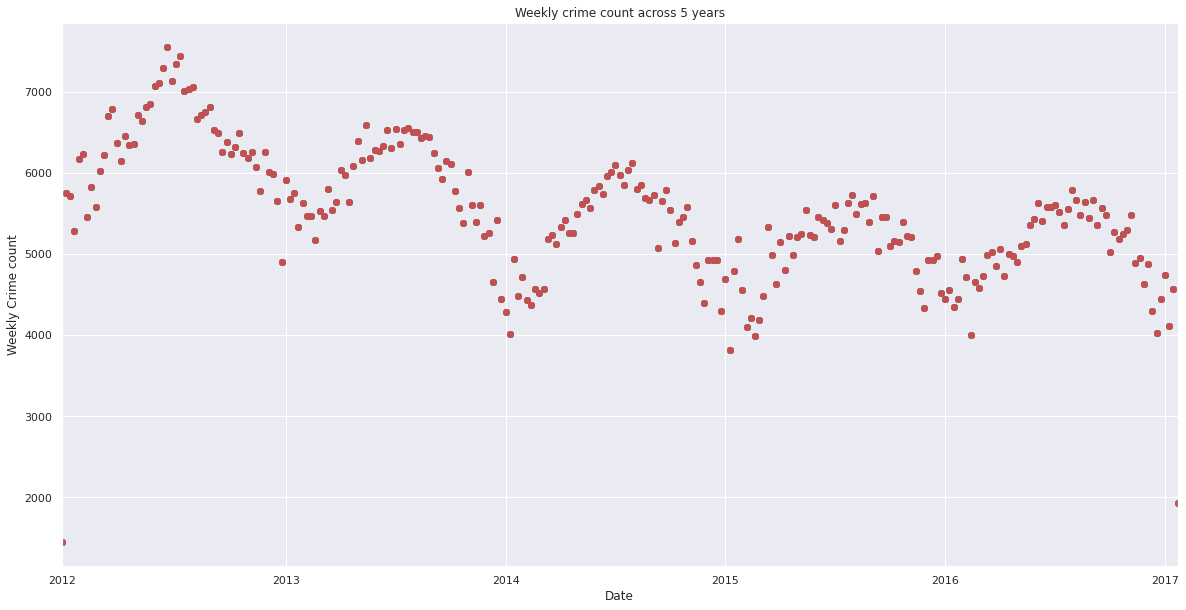

In [43]:
ax = police_data.resample('1W').count().plot(linestyle='None', legend=False)
ax.set_ylabel('Weekly Crime count')
ax.set_title('Weekly crime count across 5 years')

Text(0.5, 1.0, 'Daily crime count over the years 2015-2016')

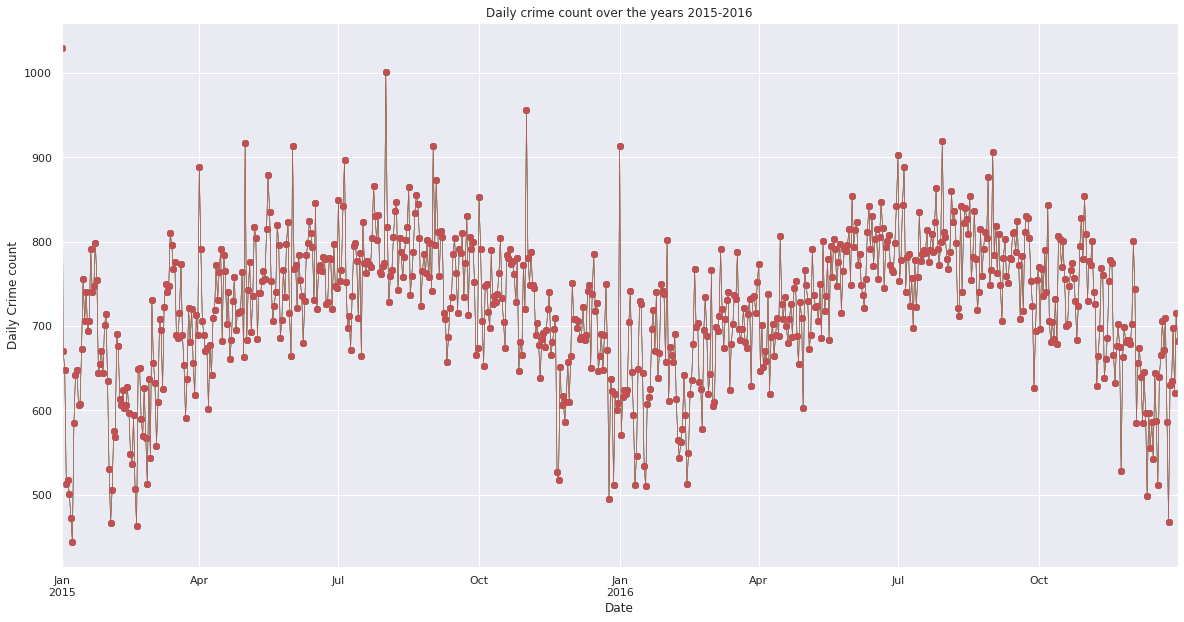

In [44]:
ax = police_data.loc['2015':'2016'].resample('1d').count().plot(linestyle='-', legend=False)
ax.set_ylabel('Daily Crime count')
ax.set_title('Daily crime count over the years 2015-2016')

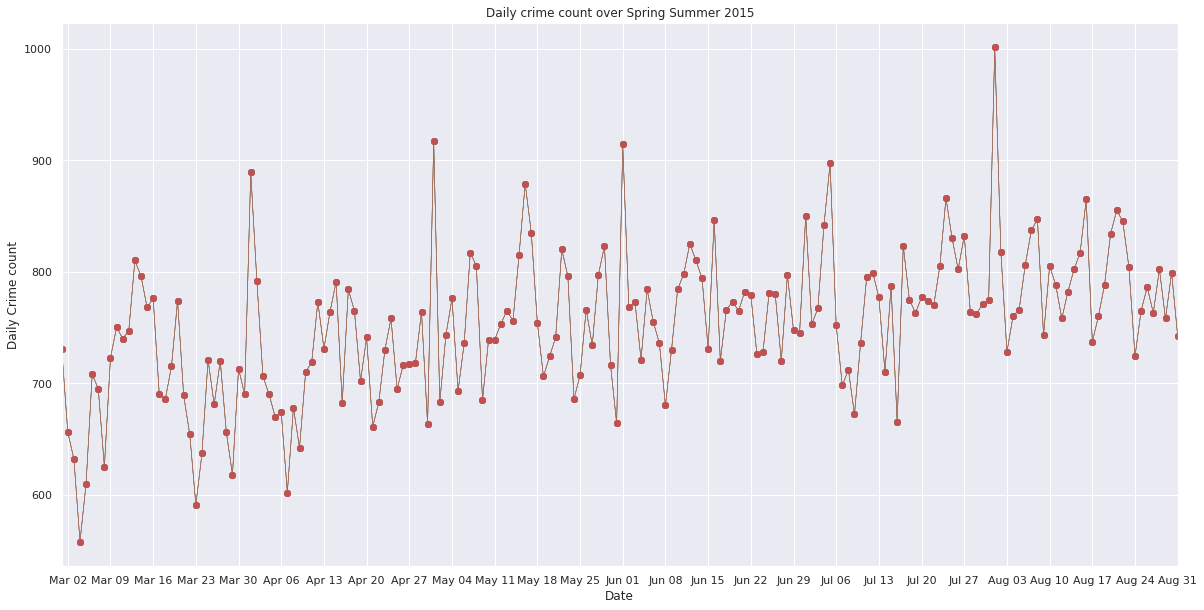

In [45]:
ax = police_data.loc['2015/03':'2015/08'].resample('1d').count().plot(linestyle='-', legend=False)
ax.set_ylabel('Daily Crime count')
ax.set_title('Daily crime count over Spring Summer 2015')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

## Autoregressive Integrated Moving Average Model

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series
  stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.


In [ ]:
# remove all columns
print(f'Shape of table: {police_data.shape}')
drop_attributes = [
    'Arrest Status',
    'Domestic Status',
    'District',
    'FBI Code'
]
police_data = police_data.drop(columns=drop_attributes)


In [84]:
# Create period table, with one column for crime count
print(f'Shape of table before resampling: {police_data.shape}')

police_data['Crime Count'] = ""
daily_series = police_data.resample(rule='1d', kind='period').count()
print(f'Shape of period array: {daily_series.shape}')
print(daily_series.info())
daily_series.head(2)


Shape of table before resampling: (1456713, 1)
Shape of period array: (1845, 1)
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1845 entries, 2012-01-01 to 2017-01-18
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Crime Count  1845 non-null   int64
dtypes: int64(1)
memory usage: 28.8 KB
None


,Crime Count
Date,
2012-01-01,1451
2012-01-02,700


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

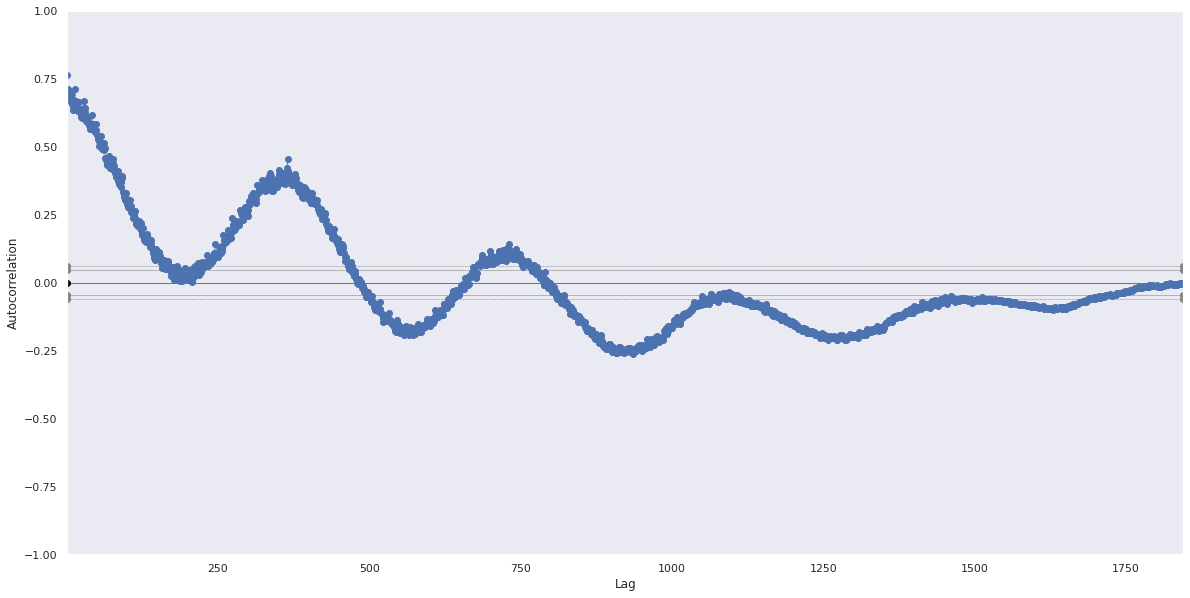

In [74]:
from pandas.plotting import autocorrelation_plot
daily_series = police_data.resample(rule ='1d', kind = 'period').count()

# This can help as choose the lag to be used in the Arima model, p value
autocorrelation_plot(daily_series)

In [53]:
from statsmodels.tsa.arima.model import ARIMA

daily_series

,Arrest Status,Domestic Status,District,FBI Code
Date,,,,
2012-01-01,1451,1451,1451,1451
2012-01-02,700,700,700,700
2012-01-03,805,805,805,805
2012-01-04,799,799,799,799
2012-01-05,871,871,871,871
...,...,...,...,...
2017-01-14,649,649,649,649
2017-01-15,600,600,600,600
2017-01-16,611,611,611,611


Shape of table: (1456713, 0)


KeyError: "['Arrest Status', 'Domestic Status', 'District', 'FBI Code'] not found in axis"